In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, f1_score

data_path = Path("ohsumed")

In [2]:
import string

from nltk.corpus import stopwords


def filter_and_tokenize(text):
    text = text.lower().replace('\n', ' ')

    for p in string.punctuation + string.digits:
        text = text.replace(p, ' ')

    return " ".join([t for t in text.split(' ') if len(t) > 1])

from nltk.stem import WordNetLemmatizer

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(t) for t in text.split(' ') if len(t) > 1])

english_stopwords = stopwords.words('english') + ['to', 'is', 'like', 'me', 'all', 'and',
                                                  'the', 'all', 'that', 'in', 'me',
                                                  'please', 'okay', 'do', 'does', 'doe']

def remove_stopwords(tokens):
    return [t for t in tokens if t not in english_stopwords]


def prepare(df):
    df['text'] = df['text'].apply(filter_and_tokenize)
    df['text'] = df['text'].apply(lemmatize)
    df['text'] = df.text.apply(lambda s: s.split(' '))
    df['text'] = df['text'].apply(remove_stopwords)
    df['text'] = df['text'].apply(lambda text: " ".join([t for t in text]))
    return df

In [3]:
dir = "lemmatized_wo_stopwords"
df_test = pd.read_json(data_path.joinpath(f"{dir}/test.bz2"), compression="bz2", lines=True)
df_train = pd.read_json(data_path.joinpath(f"{dir}/train.bz2"), compression="bz2", lines=True)

prepare(df_test)
prepare(df_train)

,text,label
0,skin exudate level interleukin interleukin cyt...,1
1,selective regulation activity different hemato...,1
2,lymphokineactivated killer lak cell activity c...,1
3,new monoclonal antibody chf recognize cd subse...,1
4,expression transcobalamin ii receptor human le...,1
...,...,...
10428,result contemporary radical cystectomy invasiv...,23
10429,total bladder replacement use detubularized si...,23
10430,intracavernous injection prostaglandin combina...,23
10431,fate residual fragment extracorporeal shock wa...,23


# Задание 3

Проверить гипотезу, что наличие фоновых тем позволяет улучшить качество решения задачи классификации. Проверить зависимость качества решения задачи классификации от доли фоновых тем. Проверить, как сказывается на качестве решения задачи классификации совместное применение регуляризаторов разреживания, сглаживания и де- корреляции.

# Baseline

In [4]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(df_train.iloc[:, 0])
X_test = vectorizer.transform(df_test.iloc[:, 0])

y_train = df_train.iloc[:, 1].values
y_test = df_test.iloc[:, 1].values

In [5]:
model = LinearSVC(verbose=True)
model.fit(X_train, y_train)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=True)

In [6]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [7]:
print(classification_report(y_test, y_test_pred, digits=3))
print(f1_score(y_test, y_test_pred, average="micro"))

              precision    recall  f1-score   support

           1      0.433     0.527     0.475       695
           2      0.500     0.697     0.583      1467
           3      0.434     0.188     0.263       191
           4      0.498     0.364     0.420       429
           5      0.459     0.487     0.473       400
           6      0.474     0.517     0.495       632
           7      0.470     0.445     0.457       348
           8      0.608     0.443     0.512        70
           9      0.509     0.185     0.271       146
          10      0.401     0.431     0.415       506
          11      0.421     0.275     0.333       320
          12      0.451     0.391     0.419       386
          13      0.286     0.044     0.076        91
          14      0.406     0.377     0.391       600
          15      0.516     0.475     0.495       202
          16      0.390     0.232     0.291       228
          17      0.536     0.673     0.597      1301
          18      0.385    

# Запустим что-нибудь

In [8]:
import artm
import os

from sklearn.feature_extraction.text import CountVectorizer
from numpy import array
from gensim.models.phrases import Phrases, Phraser


def to_vw_format(df, out_file, text_col='text', label_col='label'):
    with open(out_file, 'w') as f:
        for index, row in df.iterrows():
            line = f'doc_{index} {row[text_col]}'
            if label_col is not None:
                line += f' |@labels_class {row[label_col]}'
            f.write(line + '\n')
            
phrases = Phrases(df_train['text'].str.split(), min_count=10, threshold=1)
bigram = Phraser(phrases)


dataset = "ohsumed"

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [9]:
to_vw_format(df_train, os.path.join(dataset, 'train_vw.txt'))
to_vw_format(df_test, os.path.join(dataset, 'test_vw.txt'), label_col=None)

In [10]:
batches_path = os.path.join(dataset, 'batches')
batch_vectorizer = artm.BatchVectorizer(data_path=f'{dataset}/train_vw.txt',
                                        data_format='vowpal_wabbit', target_folder='batches/train/')

batches_test_path = os.path.join(dataset, 'batches_test')
batch_vectorizer_test = artm.BatchVectorizer(data_path=f'{dataset}/test_vw.txt',
                                        data_format='vowpal_wabbit', target_folder='batches/test/')

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


classifiers = [
    LinearSVC(verbose=True),
    LogisticRegression(C=100, random_state=42, n_jobs=8, max_iter=10),
    GradientBoostingClassifier(n_estimators=10, subsample=1.0, max_depth=4, random_state=42)
]

def check_model(model):
    X_train = model.transform(batch_vectorizer).values.T
    X_test = model.transform(batch_vectorizer_test).values.T

    y_train = df_train.iloc[:, 1].values
    y_test = df_test.iloc[:, 1].values
    
    res = {}
    for model_cls in classifiers:
        model_cls.fit(X_train, y_train)

        y_test_pred = model_cls.predict(X_test)
        res[model_cls.__class__.__name__] = f1_score(y_test, y_test_pred, average="micro")
        
    return res

In [19]:
def add_score(model, spec_topics=None):
    if spec_topics is None:
        spec_topics = []
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                          dictionary=batch_vectorizer.dictionary))
    
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScoreSpec',
                                           topic_names=spec_topics))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScoreSpec',
                                             topic_names=spec_topics))
    
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    

def plot_scores(model):
    plt.subplots()
    plt.plot(model.score_tracker["PerplexityScore"].value[2:])
    plt.title(f"perplexity: {model.score_tracker['PerplexityScore'].value[-1]}")


    plt.subplots()
    plt.plot(model.score_tracker["SparsityPhiScore"].value)
    plt.title(f"phi sparsity: {model.score_tracker['SparsityPhiScore'].value[-1]}")


    plt.subplots()
    plt.plot(model.score_tracker["SparsityThetaScore"].value)
    plt.title(f"theta sparsity: {model.score_tracker['SparsityThetaScore'].value[-1]}")
    
    
    plt.subplots()
    plt.plot(model.score_tracker["SparsityPhiScoreSpec"].value,)
    plt.title(f"phi sparsity spec: {model.score_tracker['SparsityPhiScoreSpec'].value[-1]}")


    plt.subplots()
    plt.plot(model.score_tracker["SparsityThetaScoreSpec"].value)
    plt.title(f"theta sparsity spec: {model.score_tracker['SparsityThetaScoreSpec'].value[-1]}")
    

## baseline

[LibLinear]

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,LinearSVC,LogisticRegression,GradientBoostingClassifier
0,0.15,0.148,0.148


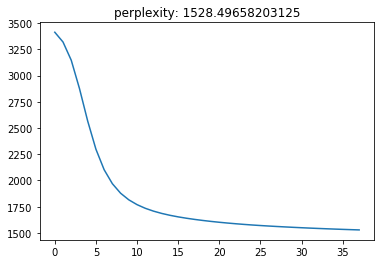

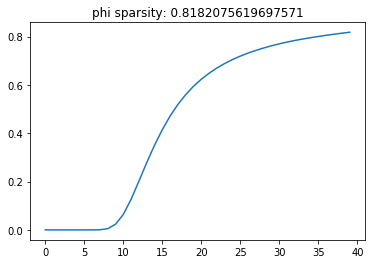

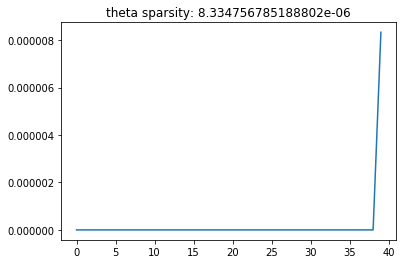

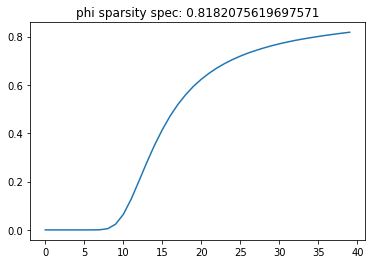

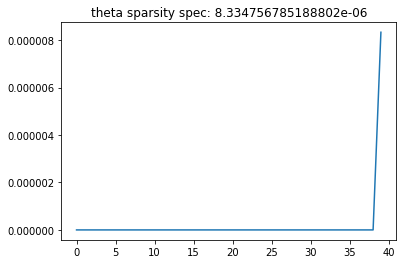

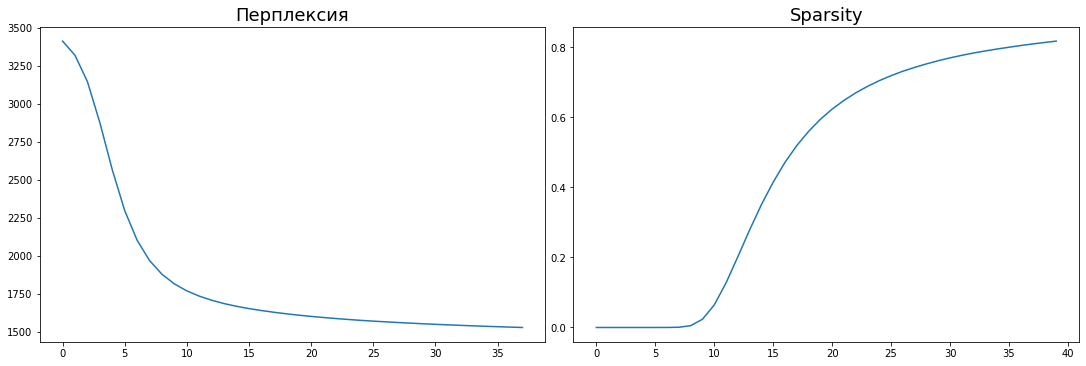

In [20]:
data_folder = "batches"

params = {
    'num_topics': 23,
    'num_back_topics': 0,
    'num_collection_passes': 40,
    'num_document_passes': 2,
    'tau_sparse': 0,
    'tau_smooth': 1e5
}

num_topics = params["num_topics"]+params["num_back_topics"]
num_back_topics = params["num_back_topics"]
num_collection_passes = params["num_collection_passes"]
num_document_passes = params["num_document_passes"]
all_topic_names = ["@topic_"+str(i) for i in range(num_topics)]
spec_topics = all_topic_names[:-num_back_topics]
bag_topics = all_topic_names[-num_back_topics:]


model = artm.ARTM(
    num_topics=num_topics, dictionary=batch_vectorizer.dictionary,
    num_document_passes=num_document_passes, cache_theta=True, class_ids={'@default_class': 1.0})

add_score(model, spec_topics=spec_topics)
model.fit_offline(batch_vectorizer, num_collection_passes=params["num_collection_passes"])

res = check_model(model)
plot_scores(model)

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18

plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
ax.title.set_text("Перплексия")
plt.plot(model.score_tracker["PerplexityScore"].value[2:])

ax = plt.subplot(1, 2, 2)
ax.title.set_text('Sparsity')
plt.plot(model.score_tracker["SparsityPhiScore"].value)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("2.png", dpi=400,)

pd.DataFrame([pd.Series(res)]).round(3)

## Добавление фоновых тем

[LibLinear]

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,LinearSVC,LogisticRegression,GradientBoostingClassifier
0,0.158,0.154,0.149


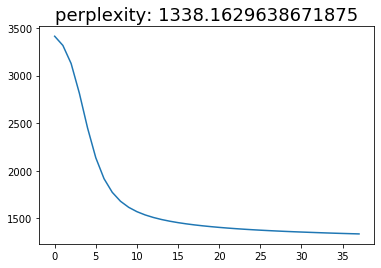

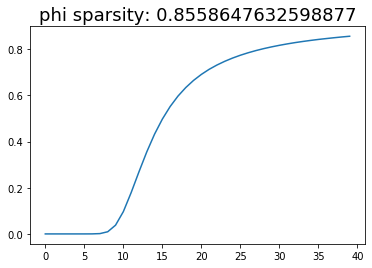

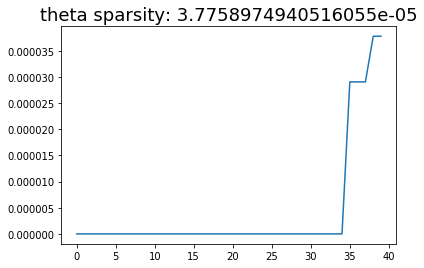

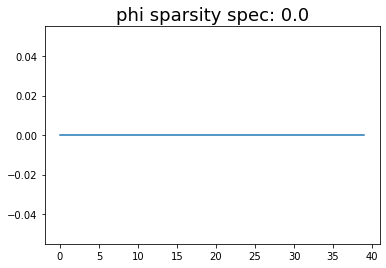

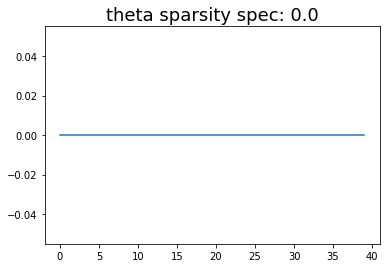

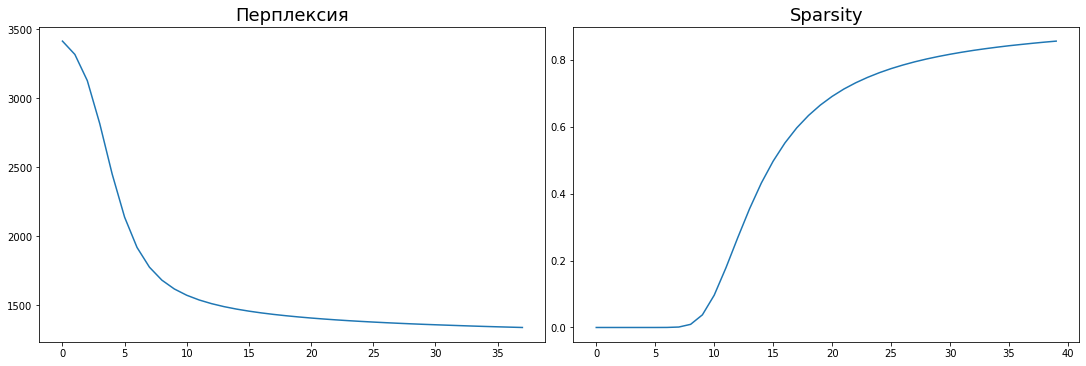

In [47]:
data_folder = "batches"

params = {
    'num_topics': 23,
    'num_back_topics': 10,
    'num_collection_passes': 40,
    'num_document_passes': 2,
    'tau_sparse': 1e-3,
    'tau_smooth': 1e5
}



num_topics = params["num_topics"]+params["num_back_topics"]
num_back_topics = params["num_back_topics"]
num_collection_passes = params["num_collection_passes"]
num_document_passes = params["num_document_passes"]
all_topic_names = ["@topic_"+str(i) for i in range(num_topics)]
spec_topics = all_topic_names[:-num_back_topics]
bag_topics = all_topic_names[-num_back_topics:]


model = artm.ARTM(
    num_topics=num_topics, dictionary=batch_vectorizer.dictionary,
    num_document_passes=num_document_passes, cache_theta=True, class_ids={'@default_class': 1.0})
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhiRegularizer', 
                                                       tau=params["tau_smooth"], 
                                                       class_ids='@default_class',
                                                       topic_names=bag_topics,
                                                       dictionary=batch_vectorizer.dictionary))

add_score(model, spec_topics=spec_topics)
model.fit_offline(batch_vectorizer, num_collection_passes=params["num_collection_passes"])

re1s = check_model(model)
plot_scores(model)

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18

plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
ax.title.set_text("Перплексия")
plt.plot(model.score_tracker["PerplexityScore"].value[2:])

ax = plt.subplot(1, 2, 2)
ax.title.set_text('Sparsity')
plt.plot(model.score_tracker["SparsityPhiScore"].value)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("3.png", dpi=400,)

pd.DataFrame([pd.Series(re1s)]).round(3)

In [24]:
params = {
    'num_topics': 23,
    'num_back_topics': 10,
    'num_collection_passes': 40,
    'num_document_passes': 3,
    'tau_sparse': -1e3,
    'tau_smooth': 1e4
}

def test_model(params):
    num_topics = params["num_topics"]+params["num_back_topics"]
    num_back_topics = params["num_back_topics"]
    num_collection_passes = params["num_collection_passes"]
    num_document_passes = params["num_document_passes"]
    all_topic_names = ["@topic_"+str(i for i in range(num_topics)]
    spec_topics = all_topic_names[:-num_back_topics]
    bag_topics = all_topic_names[-num_back_topics:]


    model = artm.ARTM(
        num_topics=num_topics, dictionary=batch_vectorizer.dictionary,
        num_document_passes=num_document_passes, cache_theta=True, class_ids={'@default_class': 1.0})
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhiRegularizer', 
                                                           tau=params["tau_smooth"], 
                                                           class_ids='@default_class',
                                                           topic_names=bag_topics,
                                                           dictionary=batch_vectorizer.dictionary))
    
    
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer', 
                                                       tau=params["tau_sparse"], 
                                                       class_ids='@default_class',
                                                       topic_names=spec_topics,
                                                       dictionary=batch_vectorizer.dictionary))
        

    add_score(model, spec_topics=spec_topics)
    model.fit_offline(batch_vectorizer, num_collection_passes=params["num_collection_passes"])

    res = check_model(model)
    return res


In [23]:
res = []
for num_back_topics in [0, 3, 10, 20, 30]:
    params['num_back_topics'] = num_back_topics
    res.append(test_model(params))

[LibLinear]

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
for i, num_back_topics in enumerate([0, 3, 10, 20, 30]):
    res[i]["n"] = num_back_topics

In [32]:
df = pd.DataFrame(res).set_index("n", drop=True)

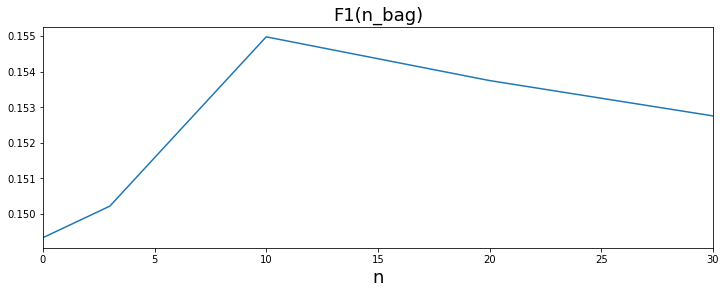

In [46]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18

plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)
ax.title.set_text("F1(n_bag)")
df.mean(1).plot(ax=ax)

pd.DataFrame([pd.Series(res)]).round(3)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("4.png", dpi=400,)

# Декорреляция

[LibLinear]

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,LinearSVC,LogisticRegression,GradientBoostingClassifier
0,0.151,0.148,0.147


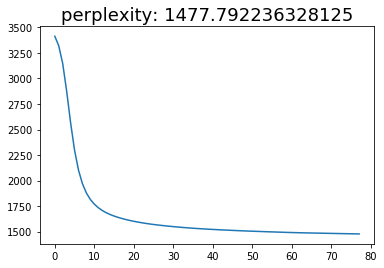

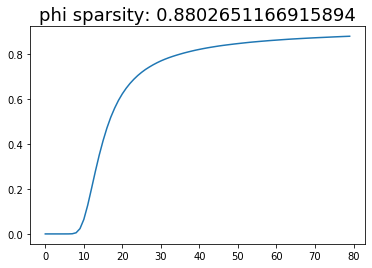

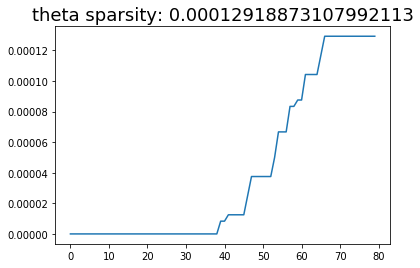

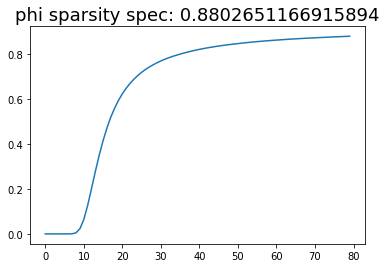

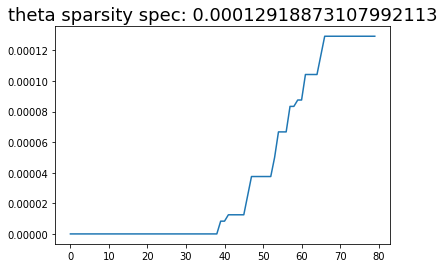

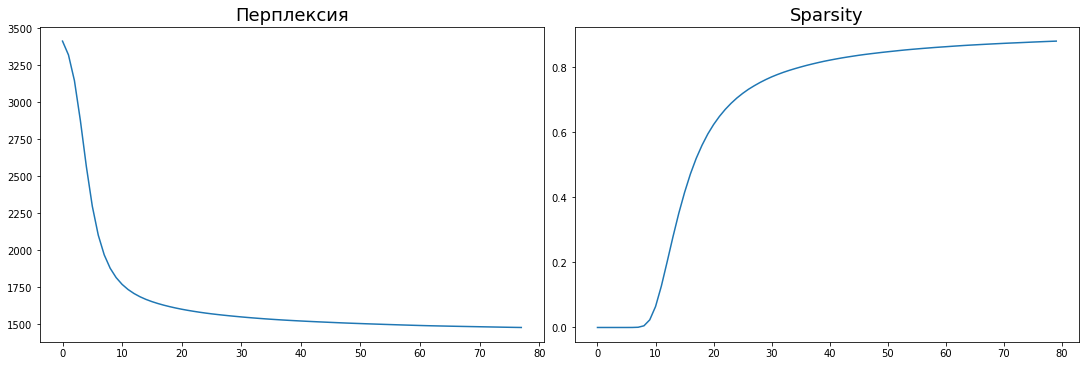

In [53]:
data_folder = "batches"

params = {
    'num_topics': 23,
    'num_back_topics': 0,
    'num_collection_passes': 80,
    'num_document_passes': 2,
    'tau_sparse': 1e-3,
    'tau_smooth': 1e5
}



num_topics = params["num_topics"]+params["num_back_topics"]
num_back_topics = params["num_back_topics"]
num_collection_passes = params["num_collection_passes"]
num_document_passes = params["num_document_passes"]
all_topic_names = ["@topic_"+str(i) for i in range(num_topics)]
spec_topics = all_topic_names[:-num_back_topics]
bag_topics = all_topic_names[-num_back_topics:]


model = artm.ARTM(
    num_topics=num_topics, dictionary=batch_vectorizer.dictionary,
    num_document_passes=num_document_passes, cache_theta=True, class_ids={'@default_class': 1.0})


model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator', tau=1e3))

add_score(model, spec_topics=spec_topics)
model.fit_offline(batch_vectorizer, num_collection_passes=params["num_collection_passes"])

re1s = check_model(model)
plot_scores(model)

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18

plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
ax.title.set_text("Перплексия")
plt.plot(model.score_tracker["PerplexityScore"].value[2:])

ax = plt.subplot(1, 2, 2)
ax.title.set_text('Sparsity')
plt.plot(model.score_tracker["SparsityPhiScore"].value)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("5.png", dpi=400,)

pd.DataFrame([pd.Series(re1s)]).round(3)



## Одновременное применение декоррелятора, сглаживания для фоновых тем и разреживания для основных

[LibLinear]

/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/glebmorgachev/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,LinearSVC,LogisticRegression,GradientBoostingClassifier
0,0.158,0.156,0.148


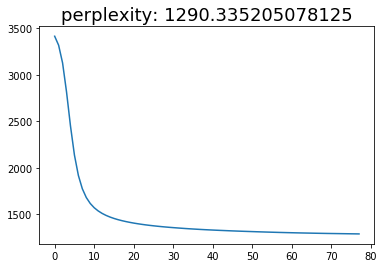

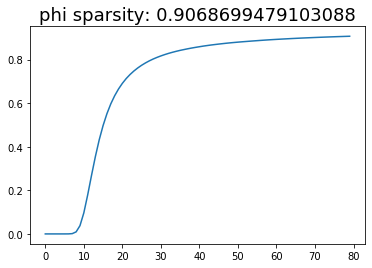

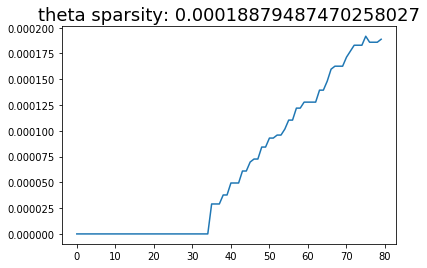

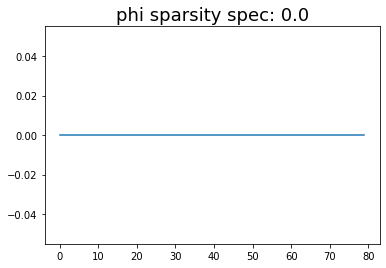

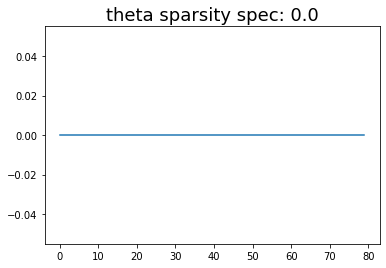

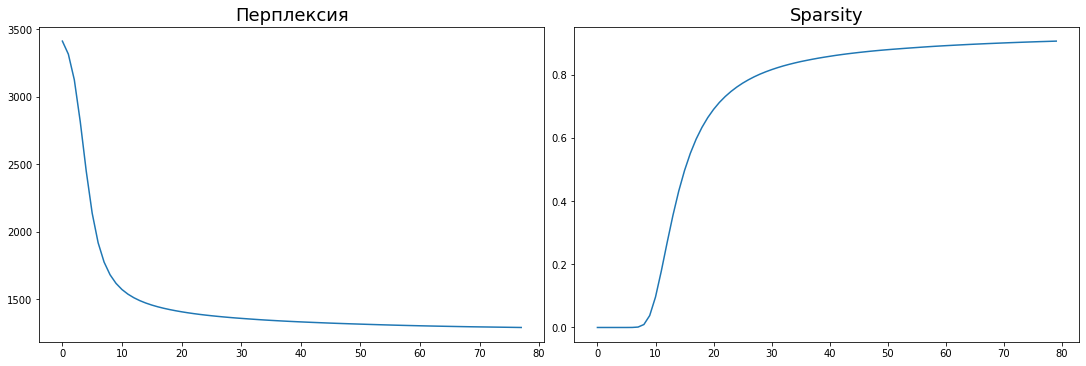

In [57]:
data_folder = "batches"

params = {
    'num_topics': 23,
    'num_back_topics': 10,
    'num_collection_passes': 80,
    'num_document_passes': 2,
    'tau_sparse': 1e-3,
    'tau_smooth': 1e5
}



num_topics = params["num_topics"]+params["num_back_topics"]
num_back_topics = params["num_back_topics"]
num_collection_passes = params["num_collection_passes"]
num_document_passes = params["num_document_passes"]
all_topic_names = ["@topic_"+str(i) for i in range(num_topics)]
spec_topics = all_topic_names[:-num_back_topics]
bag_topics = all_topic_names[-num_back_topics:]


model = artm.ARTM(
    num_topics=num_topics, dictionary=batch_vectorizer.dictionary,
    num_document_passes=num_document_passes, cache_theta=True, class_ids={'@default_class': 1.0})

model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator', tau=2e+4, topic_names=spec_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhiRegularizer', 
                                                       tau=params["tau_smooth"], 
                                                       class_ids='@default_class',
                                                       topic_names=bag_topics,
                                                       dictionary=batch_vectorizer.dictionary))


model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer', 
                                                   tau=params["tau_sparse"], 
                                                   class_ids='@default_class',
                                                   topic_names=spec_topics,
                                                   dictionary=batch_vectorizer.dictionary))

    
add_score(model, spec_topics=spec_topics)
model.fit_offline(batch_vectorizer, num_collection_passes=params["num_collection_passes"])

re1s = check_model(model)
plot_scores(model)

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18

plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
ax.title.set_text("Перплексия")
plt.plot(model.score_tracker["PerplexityScore"].value[2:])

ax = plt.subplot(1, 2, 2)
ax.title.set_text('Sparsity')
plt.plot(model.score_tracker["SparsityPhiScore"].value)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig("6.png", dpi=400,)

pd.DataFrame([pd.Series(re1s)]).round(3)


